In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
import time


In [20]:
print(torch.backends.mps.is_available())

False


In [5]:
# Load the dataset
file_path = 'household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)

# Combine and convert the Date and Time into a single Datetime column and set as index
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)
data.set_index('Datetime', inplace=True)



# Impute missing values based on the mean of the same time slot across different years
time_mean = data.groupby(data.index.time).mean()
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    fill_values = data.index.map(lambda x: time_mean.at[x.time(), col])
    data[col] = data[col].fillna(pd.Series(fill_values, index=data.index))

# Calculate the new feature 'Active_Energy_Not_Measured'
data['Active_Energy_Not_Measured'] = (data['Global_active_power'] * 1000 / 60) - (data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3'])

## Resample the dataset to every 15 minutes
data_resampled = data.resample('15min').mean()

# Display the first few rows of the resampled dataframe to verify
data_resampled.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_Energy_Not_Measured
Datetime,,,,,,,,
2006-12-16 17:15:00,4.587333,0.484000,234.366667,19.700000,0.0,1.333333,16.833333,58.288889
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667,51.411111
2006-12-16 17:45:00,4.159333,0.028267,234.630000,17.786667,0.0,0.000000,16.866667,52.455556
2006-12-16 18:00:00,4.121067,0.152533,235.566000,17.706667,0.0,19.933333,17.000000,31.751111
2006-12-16 18:15:00,3.768533,0.017200,234.803333,16.226667,0.0,2.866667,16.933333,43.008889


In [6]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138352 entries, 2006-12-16 17:15:00 to 2010-11-26 21:00:00
Freq: 15T
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Global_active_power         138352 non-null  float64
 1   Global_reactive_power       138352 non-null  float64
 2   Voltage                     138352 non-null  float64
 3   Global_intensity            138352 non-null  float64
 4   Sub_metering_1              138352 non-null  float64
 5   Sub_metering_2              138352 non-null  float64
 6   Sub_metering_3              138352 non-null  float64
 7   Active_Energy_Not_Measured  138352 non-null  float64
dtypes: float64(8)
memory usage: 9.5 MB


In [7]:
# Split the data into training and test sets by holding out the last year
test_start_date = '2009-12-01'
train_data = data_resampled[:test_start_date]
test_data = data_resampled[test_start_date:]

# For validation, split the remaining training data by holding out one month every five months
train_indices = []
val_indices = []

current_date = train_data.index.min()
end_date = train_data.index.max()

while current_date <= end_date:
    month_start = current_date
    month_end = month_start + pd.DateOffset(months=1)
    five_month_end = month_start + pd.DateOffset(months=5)
    
    # Add the indices of the current month to validation, rest to train
    month_indices = train_data[month_start:month_end].index
    train_month_indices = train_data[month_end:five_month_end].index
    
    val_indices.extend(month_indices)
    train_indices.extend(train_month_indices)
    
    # Move current date by five months
    current_date = five_month_end

train_final = train_data.loc[train_indices]
val_final = train_data.loc[val_indices]

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_final.values)
val_scaled = scaler.transform(val_final.values)
test_scaled = scaler.transform(test_data.values)

# Display the first few rows of the resampled dataframe to verify
train_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81607 entries, 2007-01-16 17:15:00 to 2009-11-16 17:15:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Global_active_power         81607 non-null  float64
 1   Global_reactive_power       81607 non-null  float64
 2   Voltage                     81607 non-null  float64
 3   Global_intensity            81607 non-null  float64
 4   Sub_metering_1              81607 non-null  float64
 5   Sub_metering_2              81607 non-null  float64
 6   Sub_metering_3              81607 non-null  float64
 7   Active_Energy_Not_Measured  81607 non-null  float64
dtypes: float64(8)
memory usage: 5.6 MB


In [8]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :-1])  # all features except the target
        y.append(data[i+n_steps, 0])  # target feature
    return np.array(X), np.array(y)

# Number of time steps to look back
n_steps = 96  # corresponds to 1 day (24 hours * 4 intervals per hour)

# Create sequences for training, validation, and testing sets
X_train, y_train = create_sequences(train_scaled, n_steps)
X_val, y_val = create_sequences(val_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

In [21]:
def ERNN(
    input_shape,
    output_size,
    loss,
    optimizer,
    recurrent_units=[64],
    recurrent_dropout=0,
    return_sequences=False,
    dense_layers=[],
    dense_dropout=0,
    out_activation="linear",
):
    """Elman Recurrent Neural Network (ERNN).

    Args:
        input_shape (tuple): Shape of the input data
        output_size (int): Number of neurons of the last layer.
        loss (tf.keras.Loss): Loss to be use for training.
        optimizer (tf.keras.Optimizer): Optimizer that implements theraining algorithm.
        recurrent_units (list, optional): Number of recurrent units for each ERNN layer.
            Defaults to [64].
        recurrent_dropout (int between 0 and 1, optional): Fraction of the input units to drop.
            Defaults to 0.
        return_sequences (bool, optional): Whether to return the last output in the output sequence, or the full sequence.
            Defaults to False.
        dense_layers (list, optional): List with the number of hidden neurons for each
            layer of the dense block before the output.
            Defaults to [].
        dense_dropout (float between 0 and 1, optional): Fraction of the dense units to drop.
            Defaults to 0.0.
        out_activation (tf activation function, optional): Activation of the output layer.
            Defaults to "linear".

    Returns:
        tf.keras.Model: ERNN model
    """
    input_shape = input_shape[-len(input_shape) + 1 :]
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = inputs
    if len(input_shape) < 2:
        x = tf.keras.layers.Reshape((inputs.shape[1], 1))(x)

    # ERNN layers
    for i, u in enumerate(recurrent_units):
        return_sequences_tmp = (
            return_sequences if i == len(recurrent_units) - 1 else True
        )
        x = tf.keras.layers.SimpleRNN(
            u, return_sequences=return_sequences_tmp, dropout=recurrent_dropout
        )(x)

    # Dense layers
    if return_sequences:
        x = tf.keras.layers.Flatten()(x)
    for hidden_units in dense_layers:
        x = tf.keras.layers.Dense(hidden_units)(x)
        if dense_dropout > 0:
            x = tf.keras.layers.Dropout(dense_dropout)(x)
    x = tf.keras.layers.Dense(output_size, activation=out_activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss=loss)

    return model


In [10]:
# Check for MPS availability and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


# Assume X_train, y_train, X_val, y_val, X_test, y_test are already defined

# Convert to PyTorch tensors without specifying device here
train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(y_test)

Using device: cpu


In [13]:
print(train_features.shape)
print(train_targets.shape)

torch.Size([81511, 96, 7])
torch.Size([81511])


In [27]:

# DataLoader
train_loader = DataLoader(TensorDataset(train_features, train_targets), batch_size=64, shuffle=True)

# Initialize model, loss function, and optimizer
model = ERNN(input_shape=train_features.shape, output_size=1,loss=tf.keras.losses.MeanSquaredError(),\
             optimizer=tf.keras.optimizers.Adam(),dense_layers=[100,50])


In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(),metrics = ["MeanSquaredError","RootMeanSquaredError","MeanAbsoluteError","Accuracy"])

In [29]:
model.fit(train_features,train_targets,epochs=20)

Epoch 1/20
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 107s 39ms/step - Accuracy: 1.5950e-05 - MeanAbsoluteError: 0.0542 - MeanSquaredError: 0.0076 - RootMeanSquaredError: 0.0827 - loss: 0.0076
Epoch 2/20
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 95s 37ms/step - Accuracy: 1.9315e-05 - MeanAbsoluteError: 0.0393 - MeanSquaredError: 0.0040 - RootMeanSquaredError: 0.0632 - loss: 0.0040
Epoch 3/20
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 159s 44ms/step - Accuracy: 8.4725e-06 - MeanAbsoluteError: 0.0383 - MeanSquaredError: 0.0039 - RootMeanSquaredError: 0.0625 - loss: 0.0039
Epoch 4/20
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 104s 41ms/step - Accuracy: 2.7517e-05 - MeanAbsoluteError: 0.0381 - MeanSquaredError: 0.0039 - RootMeanSquaredError: 0.0625 - loss: 0.0039
Epoch 5/20
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - Accuracy: 1.3593e-05 - MeanAbsoluteError: 0.0375 - MeanSquaredError: 0.0038 - RootMeanSquaredError: 0.0615 - loss: 0.0038
Epoch 6/20
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - Accuracy: 2.9228e-05 - MeanAbsoluteErro

In [31]:
y_pred = model.predict(test_features)

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step


In [32]:
model.compute_metrics(test_features,test_targets,y_pred)

{'Accuracy': 1.7232465324923396e-05,
 'MeanAbsoluteError': 0.03559999540448189,
 'MeanSquaredError': 0.0035653102677315474,
 'RootMeanSquaredError': 0.059710219502449036,
 'loss': 0.0037747190799564123}

In [36]:
#y_predt = scaler.inverse_transform(y_pred) 
y_predt = y_pred

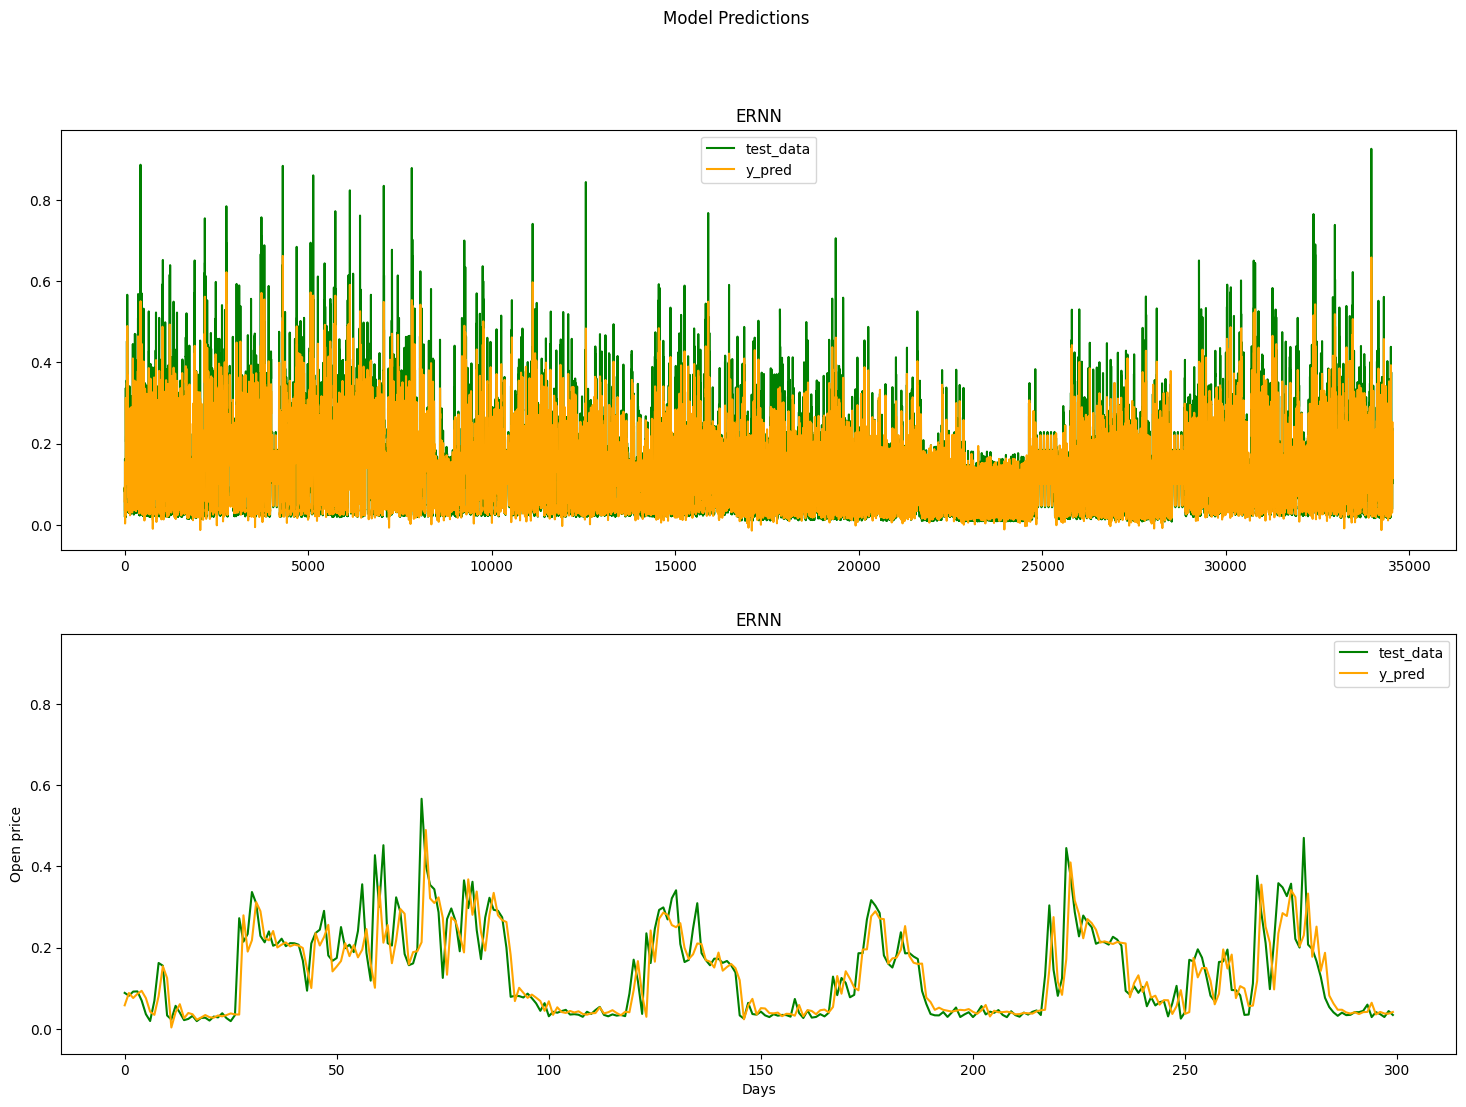

In [49]:
fig, axs = plt.subplots(2,figsize =(18,12),sharex=False, sharey=True)
fig.suptitle('Model Predictions')

#Plot for LSTM predictions



axs[0].plot( test_targets, label = "test_data", color = "g")
axs[0].plot( y_predt, label = "y_pred", color = "orange")
axs[0].legend()
axs[0].title.set_text("ERNN")

axs[1].plot( test_targets[:300], label = "test_data", color = "g")
axs[1].plot( y_predt[:300], label = "y_pred", color = "orange")
axs[1].legend()
axs[1].title.set_text("ERNN")

    
plt.xlabel("Days")
plt.ylabel("Open price")
 
plt.show()